# SVM Model

## Libraries

In [1]:
# import needed libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import nltk
import gensim.downloader as api

# Download stop words
nltk.download('stopwords')



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Loading dataset

In [3]:
# Load the dataset
data = pd.read_csv("/content/Restaurant reviews.csv")
data.shape
data.head()


,Restaurant,Reviewer,Review,Rating,Metadata,Time,Pictures,7514
0,Beyond Flavours,Rusha Chakraborty,"The ambience was good, food was quite good . h...",5,"1 Review , 2 Followers",5/25/2019 15:54,0,2447.0
1,Beyond Flavours,Anusha Tirumalaneedi,Ambience is too good for a pleasant evening. S...,5,"3 Reviews , 2 Followers",5/25/2019 14:20,0,NaN
2,Beyond Flavours,Ashok Shekhawat,A must try.. great food great ambience. Thnx f...,5,"2 Reviews , 3 Followers",5/24/2019 22:54,0,NaN
3,Beyond Flavours,Swapnil Sarkar,Soumen das and Arun was a great guy. Only beca...,5,"1 Review , 1 Follower",5/24/2019 22:11,0,NaN
4,Beyond Flavours,Dileep,Food is good.we ordered Kodi drumsticks and ba...,5,"3 Reviews , 2 Followers",5/24/2019 21:37,0,NaN


## Preprocessing

In [4]:
new_data = data[['Review', 'Rating']]
# Checking the missing values
new_data.isnull().sum()

,0
Review,45
Rating,38


In [5]:
# Drop rows with missing values in the 'review' & 'rating' column
new_data = new_data.dropna()

# Confirm that there are no more missing values
new_data.isnull().sum()


# Now Proceed with the cleaned data


,0
Review,0
Rating,0


In [6]:
# Convert 'Rating' column to numeric, forcing non-numeric values to NaN
new_data['Rating'] = pd.to_numeric(new_data['Rating'], errors='coerce')

# Drop rows with NaN values in 'Rating' column
new_data = new_data.dropna(subset=['Rating'])

# Apply the lambda function to define sentiment labels based on ratings
new_data['Sentiment'] = new_data['Rating'].apply(lambda x: 1 if x > 3 else 0)

<ipython-input-6-58b0aaf32d09>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['Sentiment'] = new_data['Rating'].apply(lambda x: 1 if x > 3 else 0)


In [7]:
# Assuming 'review' is the text column and 'rating' is the target
X = new_data['Review']
Y = new_data['Sentiment']

In [8]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

# Basic preprocessing with stop words and stemming options
def preprocess_text(text, remove_stopwords=True, use_stemming=True):
    text = text.lower()
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W+', ' ', text)  # Remove non-word characters
    words = text.split()

    if remove_stopwords:
        words = [word for word in words if word not in stop_words]

    if use_stemming:
        words = [stemmer.stem(word) for word in words]

    return ' '.join(words)

In [9]:
# Preprocessing variations
X_no_stopwords_stemming = X.apply(lambda text: preprocess_text(text, remove_stopwords=True, use_stemming=True))
X_stopwords_stemming = X.apply(lambda text: preprocess_text(text, remove_stopwords=False, use_stemming=True))
X_no_stopwords_no_stemming = X.apply(lambda text: preprocess_text(text, remove_stopwords=True, use_stemming=False))
X_stopwords_no_stemming = X.apply(lambda text: preprocess_text(text, remove_stopwords=False, use_stemming=False))

## Feature Extraction with TF-IDF

In [10]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))

# TF-IDF transformations
X_tfidf_no_stopwords_stemming = tfidf_vectorizer.fit_transform(X_no_stopwords_stemming)
X_tfidf_stopwords_stemming = tfidf_vectorizer.fit_transform(X_stopwords_stemming)
X_tfidf_no_stopwords_no_stemming = tfidf_vectorizer.fit_transform(X_no_stopwords_no_stemming)
X_tfidf_stopwords_no_stemming = tfidf_vectorizer.fit_transform(X_stopwords_no_stemming)

## Feature Extraction with Word Embeddings

In [11]:
# Load pre-trained GloVe embeddings
word_vectors = api.load("glove-wiki-gigaword-100")  # 100-dimensional embeddings

def get_word_embeddings(text):
    words = text.split()
    word_vecs = [word_vectors[word] for word in words if word in word_vectors]
    if word_vecs:
        return np.mean(word_vecs, axis=0)
    else:
        return np.zeros(word_vectors.vector_size)

# Apply embedding transformation for each preprocessing variation
X_embed_no_stopwords_stemming = np.vstack(X_no_stopwords_stemming.apply(get_word_embeddings))
X_embed_stopwords_stemming = np.vstack(X_stopwords_stemming.apply(get_word_embeddings))
X_embed_no_stopwords_no_stemming = np.vstack(X_no_stopwords_no_stemming.apply(get_word_embeddings))
X_embed_stopwords_no_stemming = np.vstack(X_stopwords_no_stemming.apply(get_word_embeddings))

[==================================================] 100.0% 128.1/128.1MB downloaded


In [12]:
# Train-Test splits for TF-IDF and Word Embeddings
X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X_tfidf_no_stopwords_stemming, Y, test_size=0.2, random_state=42)
X_train_embed, X_test_embed, y_train, y_test = train_test_split(X_embed_no_stopwords_stemming, Y, test_size=0.2, random_state=42)

## Training and Hyperparameter Tuning

In [13]:
# Define SVM model and parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

# Initialize SVM and perform Grid Search with TF-IDF
svm = SVC()


In [14]:
# Grid search with cross-validation
grid_search_tfidf = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_tfidf.fit(X_train_tfidf, y_train)

grid_search_embed = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search_embed.fit(X_train_embed, y_train)

GridSearchCV(cv=5, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']},
             scoring='accuracy')

## Evaluation

In [15]:
# TF-IDF model evaluation
best_svm_tfidf = grid_search_tfidf.best_estimator_
y_pred_tfidf = best_svm_tfidf.predict(X_test_tfidf)

print("TF-IDF Model Performance:")
print("Best Parameters:", grid_search_tfidf.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf, target_names=['Negative', 'Positive']))

# Word Embedding model evaluation
best_svm_embed = grid_search_embed.best_estimator_
y_pred_embed = best_svm_embed.predict(X_test_embed)

print("Word Embedding Model Performance:")
print("Best Parameters:", grid_search_embed.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_embed))
print(classification_report(y_test, y_pred_embed, target_names=['Negative', 'Positive']))

TF-IDF Model Performance:
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.8814665996986439
              precision    recall  f1-score   support

    Negative       0.88      0.79      0.83       734
    Positive       0.88      0.94      0.91      1257

    accuracy                           0.88      1991
   macro avg       0.88      0.86      0.87      1991
weighted avg       0.88      0.88      0.88      1991

Word Embedding Model Performance:
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.8036162732295329
              precision    recall  f1-score   support

    Negative       0.77      0.67      0.72       734
    Positive       0.82      0.88      0.85      1257

    accuracy                           0.80      1991
   macro avg       0.79      0.78      0.78      1991
weighted avg       0.80      0.80      0.80      1991



##  Ablation Study

### All preprocessing variations with different configurations:



1. TF-IDF + Stop Words + Stemming
2. TF-IDF + No Stop Words + Stemming
3. TF-IDF + Stop Words + No Stemming
4. TF-IDF + No Stop Words + No Stemming
5. Word Embeddings + Stop Words + Stemming
6. Word Embeddings + No Stop Words + Stemming
7. Word Embeddings + Stop Words + No Stemming
8. Word Embeddings + No Stop Words + No Stemming

In [16]:
# Define a list of configurations
configurations = [
    ("TF-IDF", True, True),    # TF-IDF, remove stop words, with stemming
    ("TF-IDF", True, False),   # TF-IDF, remove stop words, no stemming
    ("TF-IDF", False, True),   # TF-IDF, keep stop words, with stemming
    ("TF-IDF", False, False),  # TF-IDF, keep stop words, no stemming
    ("Embeddings", True, True),    # Word Embeddings, remove stop words, with stemming
    ("Embeddings", True, False),   # Word Embeddings, remove stop words, no stemming
    ("Embeddings", False, True),   # Word Embeddings, keep stop words, with stemming
    ("Embeddings", False, False)   # Word Embeddings, keep stop words, no stemming
]



In [17]:
# Helper function to preprocess text and extract features
def extract_features(config_type, remove_stopwords, use_stemming, X_data):
    # Apply preprocessing
    X_preprocessed = X_data.apply(lambda text: preprocess_text(text, remove_stopwords, use_stemming))

    if config_type == "TF-IDF":
        vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
        return vectorizer.fit_transform(X_preprocessed)

    elif config_type == "Embeddings":
        return np.vstack(X_preprocessed.apply(get_word_embeddings))

In [20]:
# Track results
results = []

# Loop over each configuration
for config_type, remove_stopwords, use_stemming in configurations:
    print(f"Configuration: {config_type}, Remove Stopwords: {remove_stopwords}, Stemming: {use_stemming}")

    # Extract features based on the configuration
    X_features = extract_features(config_type, remove_stopwords, use_stemming, X)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_features, Y, test_size=0.2, random_state=42)

    # Define and train SVM model with Grid Search
    SVM = SVC()
    grid_search = GridSearchCV(SVM, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Best model and evaluation
    best_svm = grid_search.best_estimator_
    y_pred = best_svm.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=['Negative', 'Positive'], output_dict=True)

    # Print and store results
    print("Best Parameters:", grid_search.best_params_)
    print("Accuracy:", accuracy)
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

    results.append({
        "Configuration": f"{config_type}, Stopwords: {remove_stopwords}, Stemming: {use_stemming}",
        "Best Parameters": grid_search.best_params_,
        "Accuracy": accuracy,
        "Report": report
    })


Configuration: TF-IDF, Remove Stopwords: True, Stemming: True
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.8814665996986439
              precision    recall  f1-score   support

    Negative       0.88      0.79      0.83       734
    Positive       0.88      0.94      0.91      1257

    accuracy                           0.88      1991
   macro avg       0.88      0.86      0.87      1991
weighted avg       0.88      0.88      0.88      1991

Configuration: TF-IDF, Remove Stopwords: True, Stemming: False
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.88598694123556
              precision    recall  f1-score   support

    Negative       0.88      0.79      0.84       734
    Positive       0.89      0.94      0.91      1257

    accuracy                           0.89      1991
   macro avg       0.89      0.87      0.87      1991
weighted avg       0.89      0.89      0.88      1991

Configuration: TF-IDF, Remove Stopwords: Fa

In [21]:
# Display summarized results
for result in results:
    print(result["Configuration"])
    print("Best Parameters:", result["Best Parameters"])
    print("Accuracy:", result["Accuracy"])
    print(result["Report"])
    print("-" * 40)

TF-IDF, Stopwords: True, Stemming: True
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.8814665996986439
{'Negative': {'precision': 0.878419452887538, 'recall': 0.7874659400544959, 'f1-score': 0.8304597701149425, 'support': 734.0}, 'Positive': {'precision': 0.8829707426856714, 'recall': 0.9363564041368337, 'f1-score': 0.9088803088803089, 'support': 1257.0}, 'accuracy': 0.8814665996986439, 'macro avg': {'precision': 0.8806950977866047, 'recall': 0.8619111720956648, 'f1-score': 0.8696700394976258, 'support': 1991.0}, 'weighted avg': {'precision': 0.8812928688977106, 'recall': 0.8814665996986439, 'f1-score': 0.8799698741973462, 'support': 1991.0}}
----------------------------------------
TF-IDF, Stopwords: True, Stemming: False
Best Parameters: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Accuracy: 0.88598694123556
{'Negative': {'precision': 0.8846737481031867, 'recall': 0.7942779291553134, 'f1-score': 0.8370423546302943, 'support': 734.0}, 'Positive': {'precision'

<ipython-input-22-3654a0d0ed52>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=config_names, y=accuracies, palette="viridis")


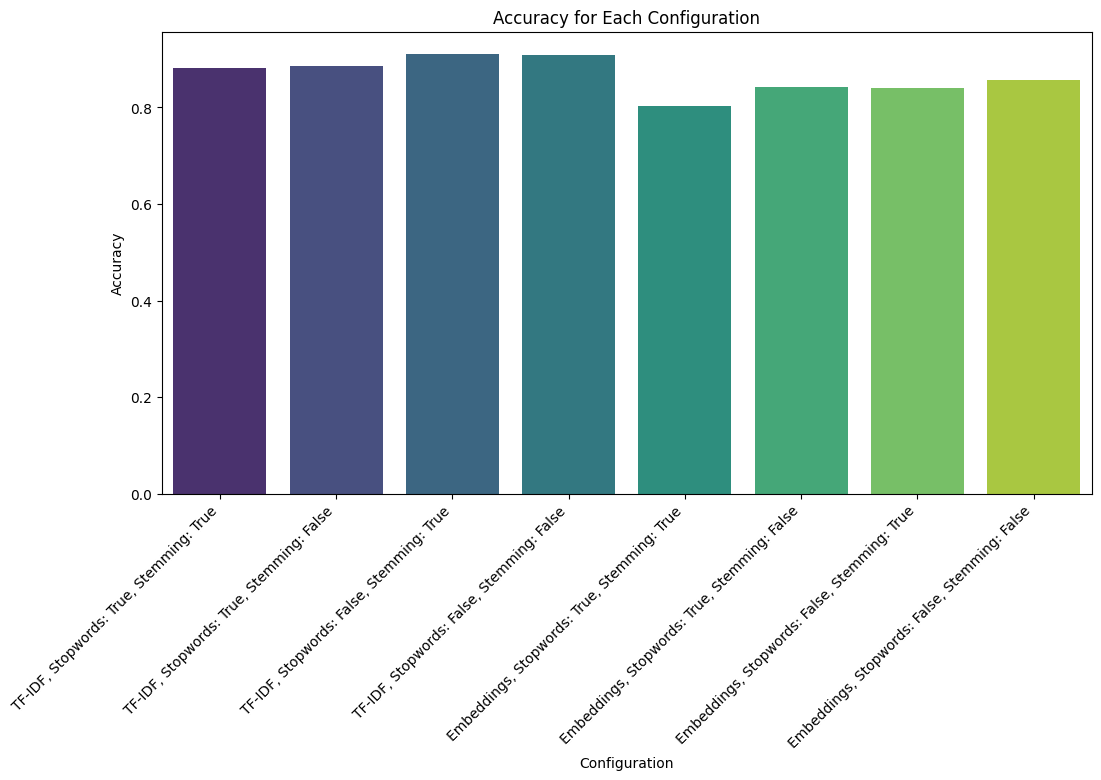

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Extract accuracy and configuration names for plotting
config_names = [result["Configuration"] for result in results]
accuracies = [result["Accuracy"] for result in results]

# Bar Plot of Accuracy Scores
plt.figure(figsize=(12, 6))
sns.barplot(x=config_names, y=accuracies, palette="viridis")
plt.xticks(rotation=45, ha="right")
plt.title("Accuracy for Each Configuration")
plt.xlabel("Configuration")
plt.ylabel("Accuracy")
plt.show()


In [23]:
for result in results:
    print("Configuration:", result["Configuration"])  # Debugging line

Configuration: TF-IDF, Stopwords: True, Stemming: True
Configuration: TF-IDF, Stopwords: True, Stemming: False
Configuration: TF-IDF, Stopwords: False, Stemming: True
Configuration: TF-IDF, Stopwords: False, Stemming: False
Configuration: Embeddings, Stopwords: True, Stemming: True
Configuration: Embeddings, Stopwords: True, Stemming: False
Configuration: Embeddings, Stopwords: False, Stemming: True
Configuration: Embeddings, Stopwords: False, Stemming: False


In [24]:

# Grid of Confusion Matrices
from sklearn.metrics import confusion_matrix

# Ensure you have the same test set split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# loop to compute confusion matrices
for result in results:
    # Assuming your Configuration is now "TF-IDF, Stopwords: True, Stemming: True"
    parts = result["Configuration"].split(", ")
    config_type = parts[0]  # Get the first part, which is the configuration type
    remove_stopwords = parts[1].split(": ")[1] == "True"  # Extract remove_stopwords
    use_stemming = parts[2].split(": ")[1] == "True"  # Extract use_stemming

    # Re-run feature extraction based on configuration
    X_features = extract_features(config_type, remove_stopwords, use_stemming, X)
    X_train, X_test, y_train, y_test = train_test_split(X_features, Y, test_size=0.2, random_state=42)

    # Use the best parameters from previous grid search to re-train the model
    best_params = result["Best Parameters"]
    svm = SVC(**best_params)
    svm.fit(X_train, y_train)

    # Generate predictions and confusion matrix
    y_pred = svm.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Add confusion matrix to result dictionary
    result["Confusion Matrix"] = conf_matrix

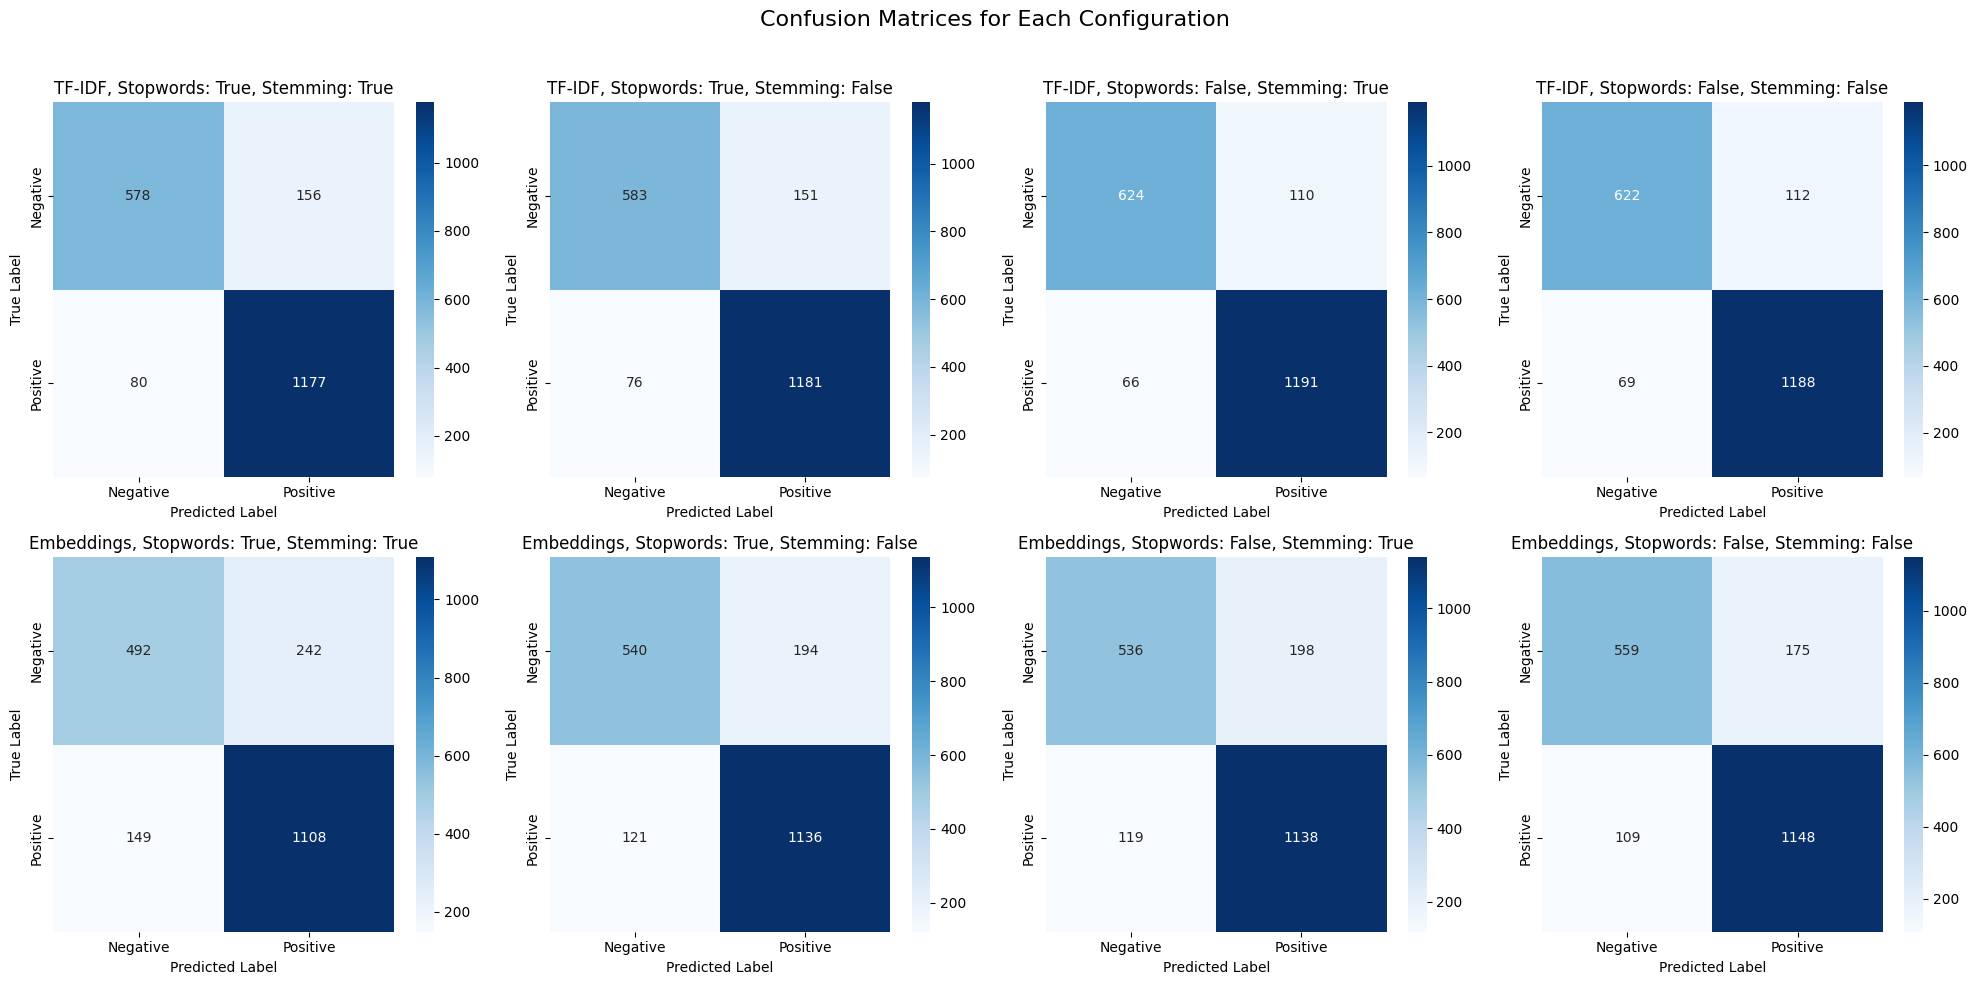

In [25]:
# Visualize Confusion Matrices
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle("Confusion Matrices for Each Configuration", fontsize=16)

for i, result in enumerate(results):
    if "Confusion Matrix" in result:
        row, col = divmod(i, 4)
        sns.heatmap(result["Confusion Matrix"], annot=True, fmt="d", cmap="Blues",
                    xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'],
                    ax=axes[row, col])
        axes[row, col].set_title(result["Configuration"])
        axes[row, col].set_xlabel("Predicted Label")
        axes[row, col].set_ylabel("True Label")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [28]:
import joblib

# Initialize variables to keep track of the best model and highest accuracy
best_accuracy = 0
best_model = None

# Find the model with the highest accuracy
for result in results:
    accuracy = result.get("Accuracy", 0)  # Make sure accuracy is stored in results
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = svm  # Assume the trained model is stored under "Model" key

# Save the best model if found
if best_model is not None:
    # Save as a joblib file
    joblib.dump(best_model, 'best_svm_model.joblib')
    print(f"Best model saved with accuracy: {best_accuracy}")

else:
    print("No model found to save.")

Best model saved with accuracy: 0.9116022099447514
